# Music Recommendation System run on GCP with 2 nodes

In [1]:
# Install pySpark
!pip install pyspark

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName('pyspark-shell')
sc = SparkContext(conf=conf)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
# Verify SparkContext
print(sc)

# Print Spark version
print(sc.version)

<SparkContext master=yarn appName=pyspark-shell>
3.1.2


In [4]:
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession

# Create spark
spark = SparkSession.builder.getOrCreate()

spark.conf.set("spark.sql.adaptive.enabled",True)
spark.conf.set("spark.sql.adaptive.skewJoin.enabled",True)
spark.conf.set("spark.sql.autoBroadcastJoinThreshold",104857600)
# spark.conf.set("spark.sql.join.preferSortMergeJoin", True)
# spark.conf.set("spark.sql.shuffle.partitions", 500)
# spark.conf.set("spark.sql.files.minPartitionNum", 400)
# spark.conf.set('spark.sql.adaptive.advisoryPartitionSizeInBytes',134217728)
# spark.conf.set('spark.sql.adaptive.coalescePartitions.initialPartitionNum',1000)
# spark.conf.set('spark.sql.files.maxPartitionBytes',67108864)

# Print spark
print(spark)

In [5]:
print(spark.conf.get('spark.sql.autoBroadcastJoinThreshold'))
print(spark.conf.get('spark.sql.shuffle.partitions'))
print(spark.conf.get('spark.sql.files.minPartitionNum'))
print(spark.conf.get('spark.sql.adaptive.advisoryPartitionSizeInBytes'))
print(spark.conf.get('spark.sql.adaptive.localShuffleReader.enabled'))
print(spark.conf.get('spark.sql.files.maxPartitionBytes'))


104857600
200
None
67108864b
true
134217728b


In [6]:
# import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, desc , col, max, monotonically_increasing_id
from pyspark.ml.feature import  StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

In [7]:
# Read triplets
file_path = 'gs://saqher20_bdpp_bucket1/triplet.csv'
triplets = spark.read.format('csv').option('delimiter',";").option('header',True).option('inferSchema',True).load(file_path)

In [8]:
# Get active users
active_users = triplets.groupBy('user').count().select('user', col('count').alias('n'))
active_users = active_users.select('user').filter(active_users.n > 10)

# Get popular songs
popular_songs = triplets.groupBy('song').count().select('song', col('count').alias('n'))
popular_songs = popular_songs.select('song').filter(popular_songs.n > 50)

In [9]:
users_songs = active_users.crossJoin(popular_songs)

In [10]:
from pyspark.sql.functions import broadcast

df = users_songs.join(triplets, ["user", "song"], "left").fillna(0)

In [11]:
from pyspark.sql.functions import spark_partition_id

df_with_partition_id = df.withColumn("partitionId", spark_partition_id()).groupBy("partitionId").count()
df_with_partition_id.show()



+-----------+--------+
|partitionId|   count|
+-----------+--------+
|          1|28525906|
|          3|31302052|
|          4| 1569126|
|          2|30819244|
|          0|30698542|
+-----------+--------+



<AxesSubplot:xlabel='partitionId'>

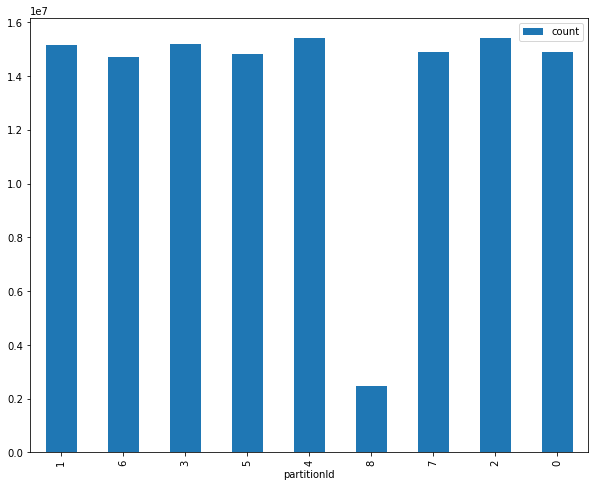

In [12]:
pdf =df_with_partition_id.toPandas()
pdf.plot(x='partitionId', y=['count'], kind='bar', figsize=(10,8))

In [13]:
# Convert string to indexes
import time
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

start = time.time()
indexers = [StringIndexer(inputCol=column, outputCol=column+"Id").fit(df) for column in list(set(df.columns)-set(['num_plays'])) ]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

end = time.time()
print("Time take is {} seconds".format(end-start))

Time take is 66.919362783432 seconds


In [14]:
# Select desired columns for ALS
df = df.select(['userId','songId', 'num_plays'])

In [15]:
# Change the data type of columns for ALS (double --> integer)
from pyspark.sql.types import IntegerType

df = df.withColumn("userId",df["userId"].cast(IntegerType()))
df = df.withColumn("songId",df["songId"].cast(IntegerType()))

In [16]:
# Order by userId
df = df.orderBy('userId')

In [17]:
# Random split into training and test sets
(training, test) = df.randomSplit([0.5,0.5])

In [18]:
# Decorator for time analysis
def time_decorator(my_func):
    def modified_func(*args, **kwargs):
        start = time.time()
        my_func(*args, **kwargs)
        end = time.time()
        print("Time taken is {} seconds".format(end - start))
    return modified_func

In [19]:
# Creating the ALS mode
USERID = 'userId'
TRACK = 'songId'
COUNT = 'num_plays'

start = time.time()
als = ALS(maxIter=1, regParam=0.01, userCol=USERID, itemCol = TRACK, ratingCol = COUNT)
model = als.fit(training)
predictions = model.transform(test)
end = time.time()

print("Time take is {} seconds".format(end-start))

21/08/25 10:49:33 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
21/08/25 10:50:14 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
21/08/25 10:51:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
21/08/25 10:51:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
21/08/25 10:51:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
21/08/25 10:51:42 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
21/08/25 10:51:53 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
21/08/25 10:51:53 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
21/08/25 10:51:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary w

Time take is 171.77457189559937 seconds


In [20]:
# Setting the number of recommendation for each user
recs = model.recommendForAllUsers(10)

In [21]:
# Shows top 20 recommendations
@time_decorator
def time_taken_in_show(recs):
  recs.show()

time_taken_in_show(recs)

21/08/25 10:52:04 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.7 MiB
21/08/25 10:52:20 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB


+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|    26|[{2544, 4.717321E...|
|    27|[{184, 2.6721763E...|
|    28|[{94, 1.4947011E-...|
|    31|[{2598, 0.0017437...|
|    34|[{2274, 1.6038211...|
|    44|[{364, 9.600844E-...|
|    53|[{0, 0.0}, {10, 0...|
|    65|[{184, 0.00696615...|
|    76|[{184, 0.01761331...|
|    78|[{94, 7.895238E-4...|
|    81|[{2544, 1.3678122...|
|    85|[{94, 0.01109137}...|
|   101|[{297, 6.172567E-...|
|   103|[{94, 0.001170287...|
|   108|[{364, 8.930477E-...|
|   115|[{1557, 4.46223E-...|
|   126|[{0, 0.0}, {10, 0...|
|   133|[{94, 5.764078E-4...|
|   137|[{184, 9.95088E-4...|
|   148|[{94, 0.011536933...|
+------+--------------------+
only showing top 20 rows

Time taken is 16.49300718307495 seconds


In [22]:
# Shows top recommendation with full details
@time_decorator
def time_taken_in_take(recs):
  print(recs.take(1))

time_taken_in_take(recs)

21/08/25 10:52:21 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.7 MiB
21/08/25 10:52:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB


[Row(userId=26, recommendations=[Row(songId=2544, rating=4.717320916824974e-05), Row(songId=2088, rating=4.189285755273886e-05), Row(songId=504, rating=3.339628528920002e-05), Row(songId=2475, rating=2.526018761273008e-05), Row(songId=1336, rating=2.449543899274431e-05), Row(songId=1652, rating=2.1626765374094248e-05), Row(songId=1323, rating=1.8783879568218254e-05), Row(songId=658, rating=1.8740282030194066e-05), Row(songId=1574, rating=1.5844983863644302e-05), Row(songId=1183, rating=1.550177694298327e-05)])]
Time taken is 7.5733349323272705 seconds
